
# Internal radiation prediction (XGBoost)

Predict `Internal Radiation` (from `radiation.csv`) using external weather (`bet_dagan_weather.csv`) and external radiation (`bet_dagan_radiation.csv`).


In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

pd.set_option('display.max_columns', 80)


In [2]:

# Load data
internal_path = 'radiation.csv'
weather_path = 'bet_dagan_weather.csv'
rad_path = 'bet_dagan_radiation.csv'

internal_raw = pd.read_csv(internal_path)
weather_raw = pd.read_csv(weather_path)
rad_raw = pd.read_csv(rad_path)

# Internal radiation
internal = internal_raw.rename(columns={'Date & Time (Summer)': 'timestamp', 'Internal Radiation': 'internal_radiation'})
internal['timestamp'] = pd.to_datetime(internal['timestamp'], dayfirst=True, errors='coerce')
internal['internal_radiation'] = pd.to_numeric(internal['internal_radiation'], errors='coerce')

# Weather
wcols = weather_raw.columns.tolist()
weather = weather_raw.rename(columns={
    wcols[0]: 'station',
    wcols[1]: 'timestamp',
    wcols[2]: 'station_pressure_hpa',
    wcols[3]: 'relative_humidity_pct',
    wcols[4]: 'temp_c',
    wcols[5]: 'temp_max_c',
    wcols[6]: 'temp_min_c',
    wcols[7]: 'temp_ground_c',
    wcols[8]: 'temp_low_c',
    wcols[9]: 'wind_dir_deg',
    wcols[10]: 'gust_dir_deg',
    wcols[11]: 'wind_speed_ms',
    wcols[12]: 'wind_speed_max_ms',
    wcols[13]: 'wind_speed_10min_max_ms',
    wcols[14]: 'wind_10min_peak_end_hhmm',
    wcols[15]: 'gust_speed_max_ms',
    wcols[16]: 'wind_dir_std_deg',
})
weather['timestamp'] = pd.to_datetime(weather['timestamp'], dayfirst=True, errors='coerce')
num_cols = [c for c in weather.columns if c not in ['station','timestamp','wind_10min_peak_end_hhmm']]
for c in num_cols:
    weather[c] = pd.to_numeric(weather[c], errors='coerce')

# External radiation
rcols = rad_raw.columns.tolist()
rad = rad_raw.rename(columns={
    rcols[0]: 'station',
    rcols[1]: 'timestamp',
    rcols[2]: 'diffuse_rad_wm2',
    rcols[3]: 'global_rad_wm2',
    rcols[4]: 'direct_rad_wm2',
})
rad['timestamp'] = pd.to_datetime(rad['timestamp'], dayfirst=True, errors='coerce')
for c in ['diffuse_rad_wm2','global_rad_wm2','direct_rad_wm2']:
    rad[c] = pd.to_numeric(rad[c], errors='coerce')

print(internal.head(2))
print(weather.head(2))
print(rad.head(2))


            timestamp  internal_radiation
0 2025-08-10 00:00:00              0.0245
1 2025-08-10 00:10:00              0.0530
   station           timestamp  station_pressure_hpa  relative_humidity_pct  \
0  בית דגן 2025-05-29 00:00:00                1009.0                     70   
1  בית דגן 2025-05-29 00:10:00                1008.9                     70   

   temp_c  temp_max_c  temp_min_c  temp_ground_c  temp_low_c  wind_dir_deg  \
0    21.5        21.5        21.4           20.8         NaN           240   
1    21.5        21.5        21.5           20.8         NaN           245   

   gust_dir_deg  wind_speed_ms  wind_speed_max_ms  wind_speed_10min_max_ms  \
0           238            3.5                4.7                      3.8   
1           244            3.9                4.6                      4.1   

  wind_10min_peak_end_hhmm  gust_speed_max_ms  wind_dir_std_deg  
0                    23:51                6.3              13.1  
1                     0:06        

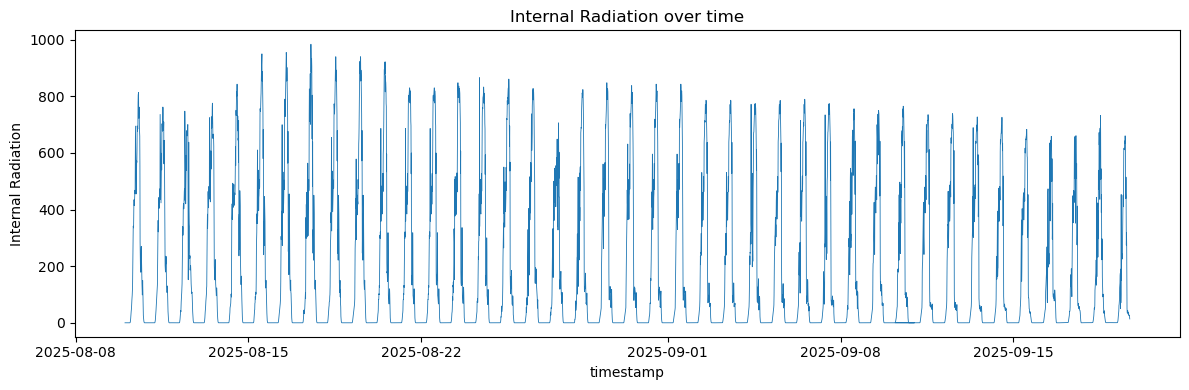

In [3]:
# Plot internal radiation time series
plt.figure(figsize=(12,4))
plt.plot(internal['timestamp'], internal['internal_radiation'], linewidth=0.6)
plt.ylabel('Internal Radiation')
plt.xlabel('timestamp')
plt.title('Internal Radiation over time')
plt.tight_layout()
plt.show()


In [4]:
# Merge and feature engineering (no lag features)
met = pd.merge(
    internal,
    pd.merge(weather.drop(columns=['station','wind_10min_peak_end_hhmm']), rad.drop(columns=['station']), on='timestamp', how='inner'),
    on='timestamp',
    how='inner'
)
na_full = [c for c in met.columns if met[c].isna().all()]
if na_full:
    print('Dropping all-NaN columns:', na_full)
    met = met.drop(columns=na_full)

fill_cols = ['relative_humidity_pct','temp_c','temp_max_c','temp_min_c','temp_ground_c','wind_speed_ms','wind_speed_max_ms','wind_speed_10min_max_ms','gust_speed_max_ms','gust_dir_deg','wind_dir_deg','global_rad_wm2','diffuse_rad_wm2','direct_rad_wm2']
for col in fill_cols:
    if col in met.columns:
        met[col] = met[col].interpolate(limit=6).ffill().bfill()

met = met.sort_values('timestamp').reset_index(drop=True)
met['month'] = met['timestamp'].dt.month
met['month_sin'] = np.sin(2*np.pi*met['month']/12)
met['month_cos'] = np.cos(2*np.pi*met['month']/12)

target_col = 'internal_radiation'
feature_cols = [c for c in met.columns if c not in [target_col, 'timestamp']]

print(f'Merged rows after cleaning: {len(met):,}')
print(f'Feature count: {len(feature_cols)}')
met.head(3)


Dropping all-NaN columns: ['temp_low_c']
Merged rows after cleaning: 5,865
Feature count: 19


,timestamp,internal_radiation,station_pressure_hpa,relative_humidity_pct,temp_c,temp_max_c,temp_min_c,temp_ground_c,wind_dir_deg,gust_dir_deg,wind_speed_ms,wind_speed_max_ms,wind_speed_10min_max_ms,gust_speed_max_ms,wind_dir_std_deg,diffuse_rad_wm2,global_rad_wm2,direct_rad_wm2,month,month_sin,month_cos
0,2025-08-10 00:00:00,0.0245,1005.8,78,28.1,28.2,28.1,27.7,235,241,1.4,1.8,1.4,2.4,15.8,0.0,0.0,0.0,8,-0.866025,-0.5
1,2025-08-10 00:10:00,0.0530,1005.6,78,28.3,28.3,28.2,28.0,243,240,1.9,2.4,1.9,2.7,10.3,0.0,0.0,0.0,8,-0.866025,-0.5
2,2025-08-10 00:20:00,0.0575,1005.6,77,28.4,28.4,28.3,28.1,232,222,1.8,2.2,2.0,2.8,10.3,0.0,0.0,0.0,8,-0.866025,-0.5


In [5]:

# Train/test split and model
X = met[feature_cols]
y = met[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

xgb_params = dict(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
)

xgb_model = XGBRegressor(**xgb_params)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)


In [6]:

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
pd.DataFrame([{'MAE': mae, 'R2_pct': r2*100}])


,MAE,R2_pct
0,27.300293,94.898992


In [7]:
# Predict internal radiation for full weather+radiation range up to 2025-08-10 (exclude Aug 10)
cutoff = pd.Timestamp('2025-08-10')
met_pred = pd.merge(
    weather.drop(columns=['station','wind_10min_peak_end_hhmm']),
    rad.drop(columns=['station']),
    on='timestamp',
    how='inner'
)
met_pred = met_pred.sort_values('timestamp')
met_pred = met_pred[met_pred['timestamp'] < cutoff]
# Drop all-NaN columns and lightly fill gaps
na_full_cols = [c for c in met_pred.columns if met_pred[c].isna().all()]
if na_full_cols:
    print('Dropping all-NaN columns:', na_full_cols)
    met_pred = met_pred.drop(columns=na_full_cols)
fill_cols = ['relative_humidity_pct','temp_c','temp_max_c','temp_min_c','temp_ground_c',
             'wind_speed_ms','wind_speed_max_ms','wind_speed_10min_max_ms','gust_speed_max_ms',
             'gust_dir_deg','wind_dir_deg','global_rad_wm2','diffuse_rad_wm2','direct_rad_wm2']
for col in fill_cols:
    if col in met_pred.columns:
        met_pred[col] = met_pred[col].interpolate(limit=6).ffill().bfill()
met_pred['month'] = met_pred['timestamp'].dt.month
met_pred['month_sin'] = np.sin(2*np.pi*met_pred['month']/12)
met_pred['month_cos'] = np.cos(2*np.pi*met_pred['month']/12)
# Align feature columns (no lags in this notebook)
for col in feature_cols:
    if col not in met_pred.columns:
        met_pred[col] = 0.0
pred_X = met_pred[feature_cols]
pred_internal = xgb_model.predict(pred_X)
pred_internal = np.where(met_pred.get('global_rad_wm2', 0) <= 0, 0, pred_internal)

pred_df = pd.DataFrame({
    'timestamp': met_pred['timestamp'].values,
    'pred_internal_radiation': np.clip(pred_internal, 0, None),
})
pred_df['timestamp_dayfirst'] = pred_df['timestamp'].dt.strftime('%d/%m/%Y %H:%M:%S')
print(f"Prediction rows: {len(pred_df):,}")
pred_df.head()
pred_out_path = 'internal_radiation_predictions_until_aug10.csv'
pred_df.to_csv(pred_out_path, index=False)
print(f"Saved predictions to {pred_out_path}")


Dropping all-NaN columns: ['temp_low_c']
Prediction rows: 10,503
Saved predictions to internal_radiation_predictions_until_aug10.csv


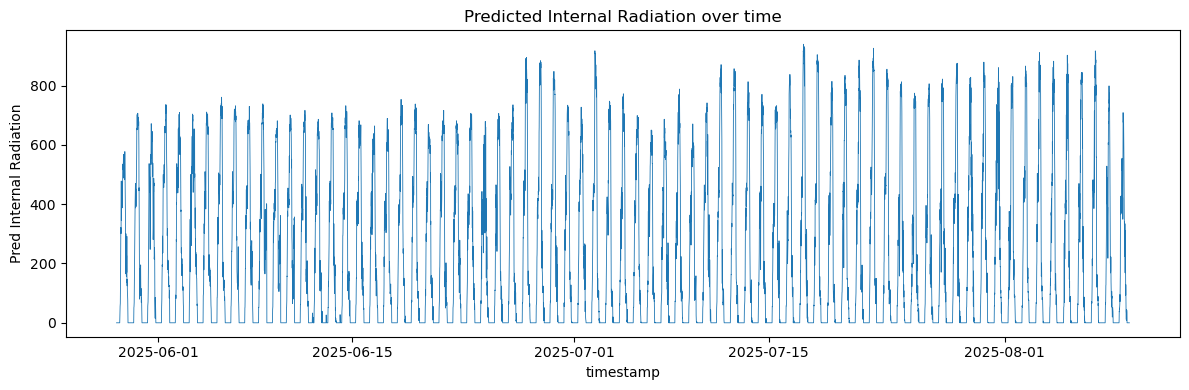

In [8]:
# Plot predicted internal radiation over time
pred_pred_path = 'internal_radiation_predictions_until_aug10.csv'
pred_pred = pd.read_csv(pred_pred_path, parse_dates=['timestamp'])
pred_pred = pred_pred.sort_values('timestamp')
plt.figure(figsize=(12,4))
plt.plot(pred_pred['timestamp'], pred_pred['pred_internal_radiation'], linewidth=0.6)
plt.ylabel('Pred Internal Radiation')
plt.xlabel('timestamp')
plt.title('Predicted Internal Radiation over time')
plt.tight_layout()
plt.show()


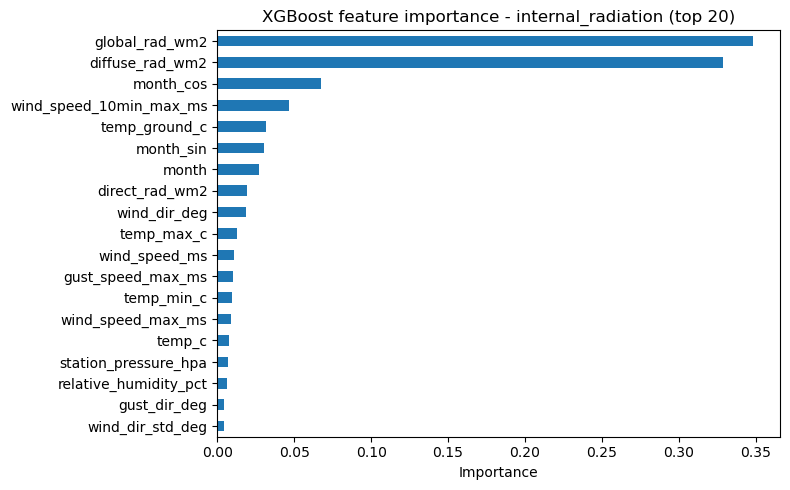

In [9]:

# Feature importance
s = pd.Series(xgb_model.feature_importances_, index=feature_cols)
top = s.sort_values(ascending=False).head(20)
plt.figure(figsize=(8,5))
top.iloc[::-1].plot(kind='barh')
plt.title('XGBoost feature importance - internal_radiation (top 20)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()
